# Micrograd

Micrograd is a tiny gradient library built from scratch using python and numpy (mainly for vectorization purposes) by me. This was my attempt to code backpropagation from scratch. In Micrograd, you can build neural networks and train them on a dataset. Andrej Karpathy's [introduction to neural networks](https://www.youtube.com/watch?v=VMj-3S1tku0) helped me greatly in developing this.

First we'll start by making a virtual environment in python so that we don't encounter any dependency issues 
and just to keep everything clean in general

```bash
mkdir micrograd && cd micrograd
python3 -m virtualenv venv
source venv/bin/activate
```

Now we'll install the only dependencies we'll need to code this library. Since we'll be keeping things simple we'll only install `jupyter` (to support notebooks), `numpy` (for fast linear algebra), and `matplotlib` (graphing library).

```bash
pip install notebook numpy matplotlib
jupyter notebook
```

In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt 
%matplotlib inline

## Derivative of a function

Now let's assume we want to take the derivative of a function at a certain value. A derivative is finding out how the function $(y)$ will respond or change with respect to the input $(x)$ if we bump it a little bit. The formula for getting the derivative of a function at a particular point is the following:
$$\frac{f(x+h) - f(x)}{h}$$

$f(x+h) - f(x)$ gives us the rise and $h$ gives us the run and when we divide $f(x+h) - f(x)$ by $h$, we get the slope. Now, why do we need a function's derivative or the slope of a function? In straightforward terms, the slope of the function will tell us if whether the function is increasing or decreasing and at what rate.
$$f(x) = 3x^2 - 4x + 5 $$

In [3]:
def f_d(x, h = 0.000001):
    d1 = 3*(x**2) - 4*x + 5
    d2 = 3*(x+h)**2 - 4*(x+h) + 5
    print(f"f'({x}) = {(d2 - d1) / h}")

In [4]:
f_d(3.0)
f_d(-3.0)
f_d(2/3)

f'(3.0) = 14.000003002223593
f'(-3.0) = -21.999997002808414
f'(0.6666666666666666) = 2.999378523327323e-06


### Let's get more complex

Now let's compute derivate of $f(a, b, c) = ab + c$ with resepect to $a$, which means $\frac{d}{da}ab + c$. We'll calculate it by the following:
$$\frac{f(a+h, b, c) - f(a, b, c)}{h}$$

In [5]:
def f_d(a, b, c, h = 0.000001):
    d1 = a * b + c
    d2 = (a + h) * b + c
    print(f"f'({a, b, c}) = {(d2 - d1) / h}")

In [6]:
f_d(2.0, -3.0, 10.0)

f'((2.0, -3.0, 10.0)) = -3.000000000419334


## Coming to Neural Networks

`Value` datastructure is one of the building blocks of our library micrograd, this kind of acts like indiviual neuron in our ANN's.

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [8]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Class `Value` represents a node in the neural network, it stores a total of 4 things with itself that we'll need to perform forward propagation and back-propagation. First is the `data` (numeric value), `operation` (the operation that lead to its creation), `gradient` (how this value is affecting the output), and `children` (nodes which created this node). By default we presume the `gradient` will be 0 to assume that it is having 0 affect on the output.

For example, let's take the function and do manual forward propagation and back propagation on this: 

$$L = (ab + d)f $$

Below is the code to do manual forward propagation as of now

In [9]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b; c.label = 'c'
d = Value(1.0, label='d')
e = c + d; e.label = 'e'
f = Value(7.0, label='f')
L = e * f; L.label = 'L'

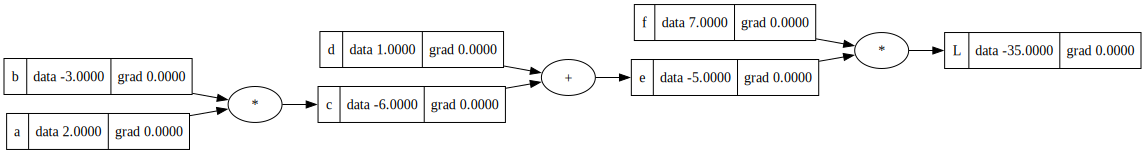

In [10]:
draw_dot(L)

Now, let's start taking derivatives to simulate manual backpropagation for our neural network. Let's begin with taking the end node i.e. L and take the derivative of it w.r.t L and since L is the function we are taking it against the gradient will be 1. This is the base case for our algorithm.

Now, we want to calculate the derivative of $L = fe$ and we'll take it w.r.t. to $f$ i.e. $\frac{dL}{df}$ and $e$ i.e. $\frac{dL}{de}$. Now, if we calculate it by hand the value of $\frac{dL}{df} = e$ and $\frac{dL}{de} = f$. You can try and calculate this by the following code too. This is called inline gradient check.

In [11]:
def lol(h = 0.001):
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label = 'c'
    d = Value(1.0, label='d')
    e = c + d; e.label = 'e'
    f = Value(7.0, label='f')
    L1 = e * f; L.label = 'L'


    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = a * b; c.label = 'c'
    d = Value(1.0, label='d')
    e = c + d; e.label = 'e'
    e.data += h
    f = Value(7.0, label='f')
    L2 = e * f; L.label = 'L'

    print("Gradient for de/dL =", (L2.data - L1.data)/h)

In [12]:
lol()

Gradient for de/dL = 7.000000000005002


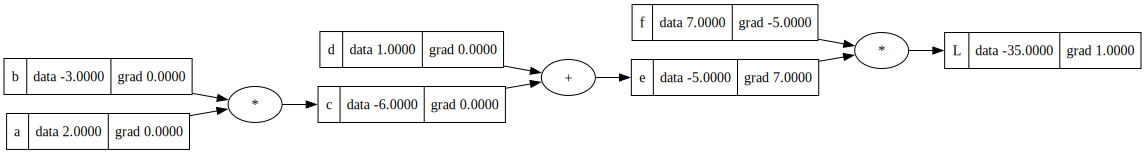

In [13]:
L.grad = 1
f.grad = L.grad * e.data
e.grad = L.grad * f.data
draw_dot(L)

As you can see the value for $\frac{dL}{de} = 1$ and it's verified. Similarly, if we wanted to calculate the gradient for $L = fe$ w.r.t $f$ and $e$ it would come out to $\frac{dL}{de} = f$ and $\frac{dL}{df} = e$ respectively.

Now we come to the most important part of backpropagation, we have calculated the gradient of $L$ w.r.t $f$ and $e$ but now we want to calculate how $L$ is affected by $d$, $c$, $a$ or $b$ which are not directly related to $L$, but instead they are related to $L$ indirectly or to say through other variables like
$$ L = f \cdot e; e = d + c$$

Now if you take a look at the graph variables like $d$ and $c$ they don't know what's going on in the end or what bigger picture they are a part of they are very small neurons in a big neural network. The big question is how do we calculate how they are affecting $L$ in the long run. When you think about it $e$ is a product of $d$ and $c$ which means that any change in $d$ or $c$ will also affect $e$ which will directly affect $L$, so there must be some relation between the change in $d$ and $c$ and the change in $f$ in affecting $L$. So, thinking about it the change in $d$ will affect $e$, which will affect $L$.

This is called the _Chain rule_ in calculus according to which "If a variable z depends on the variable y, which itself depends on the variable x (that is, y and z are dependent variables), then z depends on x as well, via the intermediate variable y." which suggests that:
$$ \frac{dz}{dx} = \frac{dz}{dy}\cdot\frac{dy}{dx}$$

Therefore, since we know that $ e = dc $ and $ \frac{de}{dd} = \frac{de}{dd} = 1.00$
$$ \frac{dL}{dd} = \frac{dL}{de} \cdot \frac{de}{dd} = 7 \cdot 1 = 7.00$$.
$$ \frac{dL}{dc} = \frac{dL}{de} \cdot \frac{de}{dc} = 7 \cdot 1 = 7.00 $$

Similarly, we can calculate the gradient of $a$ and $b$ w.r.t. $L$ since we know $c = a + b$ how it is affecting $L$ we can find out how $a$ and $b$ are affecting $L$
$$ \frac{dL}{da} = \frac{dL}{de} \cdot \frac{de}{dc} \cdot \frac{dc}{da}= 7 \cdot b = 7 \cdot -3 = -21$$.
$$ \frac{dL}{db} = \frac{dL}{de} \cdot \frac{de}{dc} \cdot \frac{dc}{db}= 7 \cdot a = 7 \cdot 2 = 14$$.

If you can see the pattern here, if a neural network has $n$ layers where $n$ is the output layer, we start from the end and calculate the gradient for neurons in the $n-1$ layer which we can do easily and is pretty straightforward and to calculate gradient for neurons in $n-2$ layer what we can do is apply chain rule for which we only need the gradient of the neuron it's affecting and multiply it with it.

Also if you noticed when we calculated the gradient for $e = c + d$ the gradient for both $c$ and $d$ came out to be $7$ which was also the gradient for $e$ which tells us that if there is an addition operation and imagine that derivative is flowing backward from $L$ the root node if it encounters an addition operation it will simply distribute the derivative to all the leaf nodes. 

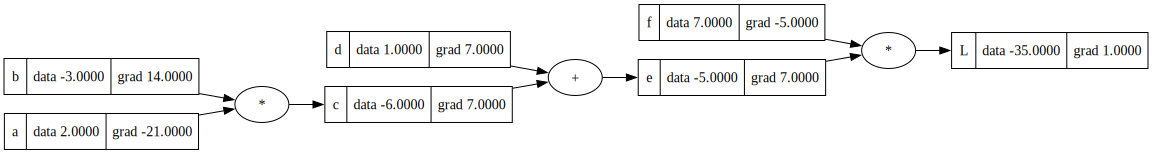

In [14]:
d.grad = e.grad * 1
c.grad = e.grad * 1
a.grad = c.grad * b.data
b.grad = c.grad * a.data
draw_dot(L)

### Backpropagation in action!

We have calculated gradients for all the nodes in our graph but what do they represent and how can we use them? Supposedly let's assume that $L$ represents the correctness of our algorithm, so we would like to increase it, right? So to increase the value of $L$, we need to move the values of the nodes in the direction their gradients. 

In [15]:
a.data += 0.001 * a.grad
b.data += 0.001 * b.grad
c.data += 0.001 * c.grad
d.data += 0.001 * d.grad
e.data += 0.001 * e.grad
f.data += 0.001 * f.grad

In [16]:
c = a * b
e = c + d
L = e * f

L.data

-34.29154653000001

As you can see the value of $L$ increased positively when we moved all the node values in the direction of their gradients. This was a single step of our optimization process when this process is performed iteratively we can optimize the value of all the nodes which can lead to us getting the results we want. 

## Neurons

We have defined a neuron below with two inputs $(x^1, x^2)$, two weights $(w^1, w^2)$ and a bias $b$. We have also introduced a new function in our Value class `tanh`. This helps us in squishing our values between $0$ and $1$. 

In [17]:
# inputs of the neuron
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')

# weights of the neuron
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1 = x1 * w1; x1w1.label='x1w1'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'

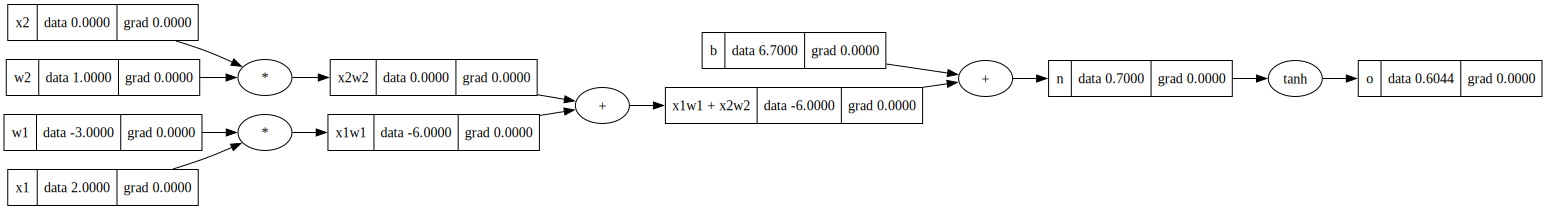

In [18]:
draw_dot(o)

Now we know the gradient of the output node $o$ will be $1.0$, coming to $n$, the derivative of $\frac{d\tanh(x)}{dx} = 1 - \tanh^2(x)$. An iteration of backpropagation is done below.

In [19]:
o.grad = 1.0
n.grad = 1 - o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad

## Automating Backpropagation
Manually doing backpropagation is a tedious task and is not practical for big neural networks. We can automate this process.

In [20]:
# inputs of the neuron
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')

# weights of the neuron
w1 = Value(-3, label='w1')
w2 = Value(1, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

x2w2 = x2 * w2; x2w2.label='x2w2'
x1w1 = x1 * w1; x1w1.label='x1w1'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'

In [21]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
w2._backward()
x1._backward()
x2._backward()

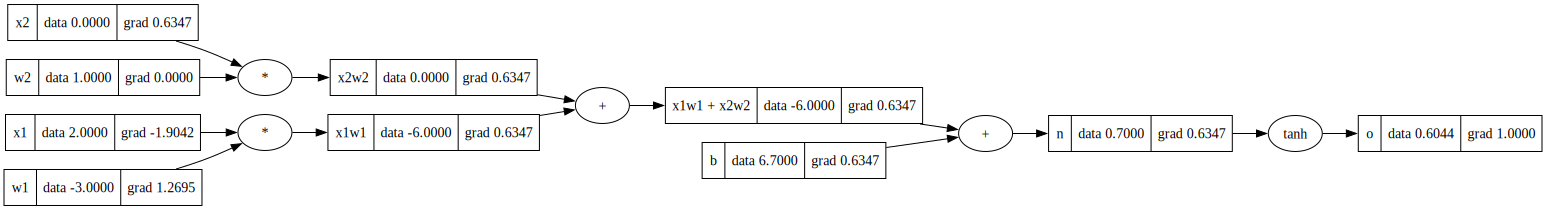

In [22]:
draw_dot(o)

In [23]:
o.backward()

### Fixing a bug in backpropagation

Our implementation of backpropagation has a bug in it, where we are not able to deal with a single node used twice or by two different nodes. The problem that's occuring is the gradient is simply overwritten by the other node. You can see in the below example the bug and you can trace it in our implmentation of backpropagation.

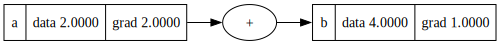

In [24]:
a = Value(2.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

As you can see gradient should be $2$ instead of $1$ and this occurs because supposedly we set the gradient once and since in this graph `self` and `other` are the same while doing the addition operation, our `_backward()` function overwrites the previously set gradient. To fix this we can simply accumulate all the gradients rather than overwriting.

```python
self.grad += 1.0 * out.grad
other.grad += 1.0 * out.grad
```

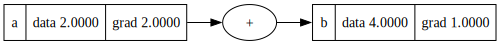

In [25]:
a = Value(2.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [26]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        self.sz = [nin] + nouts
        self.layers = [Layer(self.sz[i], self.sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6407823406063967)

In [28]:
len(n.parameters())

41

In [29]:
n = MLP(3, [4, 4, 1])

In [30]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.289544392598785),
 Value(data=-0.07246482284430447),
 Value(data=0.08244324398135364),
 Value(data=-0.564877876829011)]

In [31]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.143772391173967)

In [32]:
loss.backward()

In [33]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [39]:
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [43]:
for k in range(20):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += 0.1 * p.grad

    print(k, loss.data)

0 7.987207757311255
1 7.987478973428738
2 7.987739240918758
3 7.987989202408517
4 7.988229451475846
5 7.988460537226613
6 7.988682968369904
7 7.988897216853992
8 7.989103721117338
9 7.989302889001223
10 7.989495100364407
11 7.989680709434712
12 7.98986004692784
13 7.990033421959883
14 7.990201123776509
15 7.990363423318993
16 7.990520574644771
17 7.990672816217974
18 7.990820372083647
19 7.990963452937656
